In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets, models
from tqdm import tqdm
import os
import copy
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

In [7]:

# --- Config ---
BATCH_SIZE = 56
NUM_EPOCHS = 100
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
DATA_ROOT = "./data"

# --- Speed Boost Flags ---
torch.backends.cudnn.benchmark = True
torch.set_num_threads(os.cpu_count())

# --- Transforms ---
# Training: Heavy augmentation to prevent overfitting
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(300, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3)
])

# Validation & Test: Clean images only (Resize + Normalize)
test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Datasets & Split Logic ---
print("Preparing Datasets...")
num_cpu = os.cpu_count()

# 1. Load the official Train data twice
# Once with augmentations (for actual training)

full_train_aug = datasets.Food101(root=DATA_ROOT, split='train', transform=train_transform, download=False)

# Once without augmentations (for validation)
full_train_clean = datasets.Food101(root=DATA_ROOT, split='train', transform=test_transform, download=False)

# 2. Create the Split Indices
# We use a fixed seed so the split is reproducible
train_size = len(full_train_aug)
indices = list(range(train_size))
split = int(np.floor(0.2 * train_size)) # 20% for validation

np.random.seed(42)
np.random.shuffle(indices)

train_idx, val_idx = indices[split:], indices[:split]

# 3. Create Subsets
# train_data gets the augmented dataset, val_data gets the clean dataset

train_data = Subset(full_train_aug, train_idx)
val_data = Subset(full_train_clean, val_idx)

# 4. Load the official Test data (Held out completely)
test_data = datasets.Food101(root=DATA_ROOT, split='test', transform=test_transform, download=False)

print(f"Training Samples: {len(train_data)}")
print(f"Validation Samples: {len(val_data)}")
print(f"Test Samples: {len(test_data)}")

# --- DataLoaders ---
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=num_cpu, pin_memory=True, prefetch_factor=2)

# Validation loader (Shuffle=False is standard for validation)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=num_cpu, pin_memory=True, prefetch_factor=2)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=num_cpu, pin_memory=True, prefetch_factor=2)


# --- Model ---
print("Initializing Model...")

model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features, 101)
)

model = model.to(DEVICE)

# --- Multi-GPU ---
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)


# --- Loss & Optimizer ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=LR)



Device: cuda
Preparing Datasets...
Training Samples: 60600
Validation Samples: 15150
Test Samples: 25250
Initializing Model...
Using 2 GPUs


In [ ]:
import copy
# ------------------ Training Loop ------------------
best_loss = float('inf')
best_val_acc = 0.0
patience = 5
wait = 0
best_model_wts = copy.deepcopy(model.state_dict())

# Lists to store metrics
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("Starting Training...")
for epoch in range(NUM_EPOCHS):
    # --- TRAIN ---
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # --- VALIDATION (Using the new val_loader) ---
    model.eval()
    val_loss_accum, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]", leave=False):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_accum += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    val_loss = val_loss_accum / total
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # --- Early Stopping Check (Based on Validation Data) ---
    if val_loss < best_loss:
        best_loss = val_loss
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, "AI_food_best_model.pth")
        print("✅ Best model updated and saved.")
        wait = 0
    else:
        wait += 1
        print(f" Validation loss did not improve. Patience: {wait}/{patience}")
        if wait >= patience:
            print("🛑 Early stopping triggered.")
            break

# Load best model logic
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "AI_Food_final_best_model.pth")
print(f"Training complete. Best Val Loss: {best_loss:.4f}, Best Val Acc: {best_val_acc:.2f}%")




Starting Training...


Epoch 1/100 [Train]: 100%|██████████| 1083/1083 [16:29<00:00,  1.09it/s]


Epoch 1/100 | Train Loss: 2.8991 | Train Acc: 38.81% | Val Loss: 1.5695 | Val Acc: 69.17%
✅ Best model updated and saved.


Epoch 2/100 [Train]: 100%|██████████| 1083/1083 [18:36<00:00,  1.03s/it]


Epoch 2/100 | Train Loss: 1.7315 | Train Acc: 64.45% | Val Loss: 1.3149 | Val Acc: 75.16%
✅ Best model updated and saved.


Epoch 3/100 [Train]: 100%|██████████| 1083/1083 [19:34<00:00,  1.08s/it]


Epoch 3/100 | Train Loss: 1.4775 | Train Acc: 71.17% | Val Loss: 1.2097 | Val Acc: 78.08%
✅ Best model updated and saved.


Epoch 4/100 [Train]: 100%|██████████| 1083/1083 [18:38<00:00,  1.03s/it]


Epoch 4/100 | Train Loss: 1.3450 | Train Acc: 74.63% | Val Loss: 1.1454 | Val Acc: 79.84%
✅ Best model updated and saved.


Epoch 5/100 [Train]: 100%|██████████| 1083/1083 [18:45<00:00,  1.04s/it]


Epoch 5/100 | Train Loss: 1.2425 | Train Acc: 77.47% | Val Loss: 1.1102 | Val Acc: 81.11%
✅ Best model updated and saved.


Epoch 6/100 [Train]: 100%|██████████| 1083/1083 [18:44<00:00,  1.04s/it]


Epoch 6/100 | Train Loss: 1.1623 | Train Acc: 79.63% | Val Loss: 1.0844 | Val Acc: 81.80%
✅ Best model updated and saved.


Epoch 7/100 [Train]: 100%|██████████| 1083/1083 [18:40<00:00,  1.04s/it]


Epoch 7/100 | Train Loss: 1.0975 | Train Acc: 81.54% | Val Loss: 1.0737 | Val Acc: 82.44%
✅ Best model updated and saved.


Epoch 8/100 [Train]: 100%|██████████| 1083/1083 [18:37<00:00,  1.03s/it]


Epoch 8/100 | Train Loss: 1.0452 | Train Acc: 82.94% | Val Loss: 1.0603 | Val Acc: 82.57%
✅ Best model updated and saved.


Epoch 9/100 [Train]: 100%|██████████| 1083/1083 [18:44<00:00,  1.04s/it]


Epoch 9/100 | Train Loss: 0.9998 | Train Acc: 84.35% | Val Loss: 1.0598 | Val Acc: 82.52%
✅ Best model updated and saved.


Epoch 10/100 [Train]: 100%|██████████| 1083/1083 [18:52<00:00,  1.05s/it]


Epoch 10/100 | Train Loss: 0.9590 | Train Acc: 85.53% | Val Loss: 1.0547 | Val Acc: 82.77%
✅ Best model updated and saved.


Epoch 11/100 [Train]: 100%|██████████| 1083/1083 [18:42<00:00,  1.04s/it]


Epoch 11/100 | Train Loss: 0.9239 | Train Acc: 86.52% | Val Loss: 1.0485 | Val Acc: 83.21%
✅ Best model updated and saved.


Epoch 12/100 [Train]: 100%|██████████| 1083/1083 [18:50<00:00,  1.04s/it]


Epoch 12/100 | Train Loss: 0.8874 | Train Acc: 87.59% | Val Loss: 1.0469 | Val Acc: 83.08%
✅ Best model updated and saved.


Epoch 13/100 [Train]: 100%|██████████| 1083/1083 [18:47<00:00,  1.04s/it]


Epoch 13/100 | Train Loss: 0.8576 | Train Acc: 88.44% | Val Loss: 1.0346 | Val Acc: 83.51%
✅ Best model updated and saved.


Epoch 14/100 [Train]: 100%|██████████| 1083/1083 [18:40<00:00,  1.03s/it]


Epoch 14/100 | Train Loss: 0.8321 | Train Acc: 89.23% | Val Loss: 1.0494 | Val Acc: 83.37%
⚠️ Validation loss did not improve. Patience: 1/5


Epoch 15/100 [Train]: 100%|██████████| 1083/1083 [18:43<00:00,  1.04s/it]


Epoch 15/100 | Train Loss: 0.8082 | Train Acc: 89.93% | Val Loss: 1.0527 | Val Acc: 83.23%
⚠️ Validation loss did not improve. Patience: 2/5


Epoch 16/100 [Train]: 100%|██████████| 1083/1083 [18:48<00:00,  1.04s/it]


Epoch 16/100 | Train Loss: 0.7891 | Train Acc: 90.56% | Val Loss: 1.0639 | Val Acc: 83.19%
⚠️ Validation loss did not improve. Patience: 3/5


Epoch 17/100 [Train]: 100%|██████████| 1083/1083 [18:35<00:00,  1.03s/it]


Epoch 17/100 | Train Loss: 0.7651 | Train Acc: 91.22% | Val Loss: 1.0549 | Val Acc: 83.57%
⚠️ Validation loss did not improve. Patience: 4/5


Epoch 18/100 [Train]: 100%|██████████| 1083/1083 [18:40<00:00,  1.03s/it]
                                                                     

Epoch 18/100 | Train Loss: 0.7501 | Train Acc: 91.70% | Val Loss: 1.0588 | Val Acc: 83.46%
⚠️ Validation loss did not improve. Patience: 5/5
🛑 Early stopping triggered.
Training complete. Best Val Loss: 1.0346, Best Val Acc: 83.51%



--- 1. Running Final Evaluation on Test Set (EfficientNetB3) ---
Loading weights from AI_food_best_model.pth...


/tmp/ipykernel_30813/4225764882.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(CHECKPOINT_PATH)


Model weights loaded successfully.
Evaluating on 25250 samples...


Inference: 100%|██████████| 451/451 [00:50<00:00,  8.90it/s]



--- 2. Calculating Research Metrics ---
Calculating AUROC...

 FINAL RESULTS (EfficientNetB3):
   Top-1 Accuracy:      87.28%
   Top-5 Accuracy:      97.69%
   Balanced Accuracy:   87.28%
   Macro F1-Score:      0.8721
   Macro AUROC:         0.9974

--- 3. Generating Reliability Diagram ---
Saved 'AIFood_calibration_plot.png'

--- 4. Rare vs Common Class Performance ---
   Average F1 on Top 20 Common Classes: 0.8645
   Average F1 on Bottom 20 Rare Classes: 0.8825

--- 5. Saving Reports ---
Saved classification report to 'EffB3_Food101_classification_report.txt'
Saved confusion matrix to 'EffB3_Food101_confusion_matrix.csv'


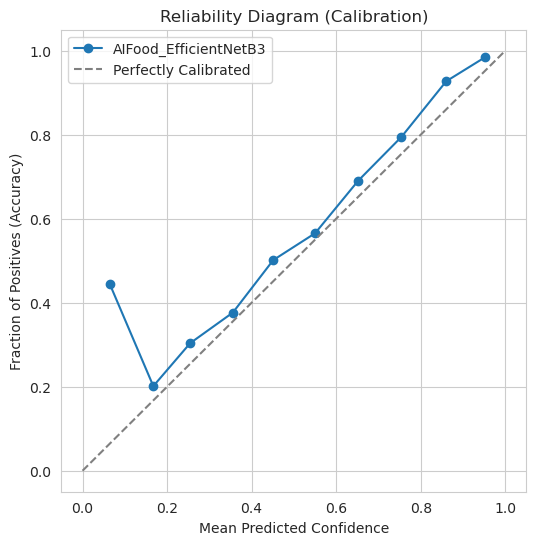

In [ ]:
# ================= FINAL EVALUATION (EfficientNetB3) =================
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import models
from sklearn.metrics import (
    accuracy_score, 
    balanced_accuracy_score, 
    classification_report, 
    confusion_matrix,
    f1_score, 
    roc_auc_score
)
from sklearn.calibration import calibration_curve
from collections import Counter

# --- 1. Setup & Configuration ---
print("\n--- 1. Running Final Evaluation on Test Set (EfficientNetB3) ---")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 101 
CHECKPOINT_PATH = "AI_food_best_model.pth"

# Ensure test_loader exists (Debugging check)
if 'test_loader' not in globals():
    raise NameError("test_loader is not defined. Please run the data loading cells first.")

# Retrieve class names automatically from the dataset
try:
    class_names = test_loader.dataset.classes
except AttributeError:
    # Fallback if classes attribute isn't directly available
    print("Warning: Could not auto-detect class names. Using numeric indices.")
    class_names = [str(i) for i in range(NUM_CLASSES)]

# --- 2. Model Initialization ---
# Must match the training architecture exactly
model_eval = models.efficientnet_b3(weights=None) 
in_features = model_eval.classifier[1].in_features
model_eval.classifier[1] = nn.Sequential(
    nn.Dropout(0.4), # Matched to your training config
    nn.Linear(in_features, NUM_CLASSES)
)

# --- 3. Load Weights ---
print(f"Loading weights from {CHECKPOINT_PATH}...")
if not torch.cuda.is_available():
    state_dict = torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu'))
else:
    state_dict = torch.load(CHECKPOINT_PATH)

# Handle DataParallel prefix (remove 'module.' if it exists)
if any(k.startswith("module.") for k in state_dict.keys()):
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_state_dict[k.replace("module.", "")] = v
    state_dict = new_state_dict

model_eval.load_state_dict(state_dict)
model_eval = model_eval.to(DEVICE)
model_eval.eval()
print("Model weights loaded successfully.")

# --- 4. Inference Loop ---
y_preds = []
y_true = []
y_probs = [] 
top5_correct = 0
total_samples = 0

print(f"Evaluating on {len(test_loader.dataset)} samples...")

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Inference"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        outputs = model_eval(images)
        
        # Capture Probabilities
        probs = torch.softmax(outputs, dim=1)
        
        # Top-1 Prediction
        _, preds = torch.max(outputs, 1)
        
        # Top-5 Prediction
        _, top5_indices = outputs.topk(5, dim=1)
        correct_tensor = top5_indices.eq(labels.view(-1, 1).expand_as(top5_indices))
        top5_correct += correct_tensor.sum().item()
        total_samples += labels.size(0)
        
        # Store results
        y_probs.extend(probs.cpu().numpy())
        y_preds.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_true = np.array(y_true)
y_preds = np.array(y_preds)
y_probs = np.array(y_probs)

# --- 5. Metrics Calculation ---
print("\n--- 2. Calculating Research Metrics ---")

final_acc = accuracy_score(y_true, y_preds)
final_bal_acc = balanced_accuracy_score(y_true, y_preds)
final_top5_acc = top5_correct / total_samples
macro_f1 = f1_score(y_true, y_preds, average='macro', zero_division=0)

print("Calculating AUROC...")
try:
    macro_auroc = roc_auc_score(y_true, y_probs, multi_class='ovr', average='macro')
except Exception as e:
    print(f"⚠️ AUROC Error (likely missing classes in test set): {e}")
    macro_auroc = 0.0

print(f"\n FINAL RESULTS (EfficientNetB3):")
print(f"   Top-1 Accuracy:      {final_acc*100:.2f}%")
print(f"   Top-5 Accuracy:      {final_top5_acc*100:.2f}%")
print(f"   Balanced Accuracy:   {final_bal_acc*100:.2f}%")
print(f"   Macro F1-Score:      {macro_f1:.4f}")
print(f"   Macro AUROC:         {macro_auroc:.4f}")

# --- 6. Reliability Diagram (Calibration) ---
print("\n--- 3. Generating Reliability Diagram ---")
confidences = np.max(y_probs, axis=1)
correctness = (y_preds == y_true).astype(int)
prob_true, prob_pred = calibration_curve(correctness, confidences, n_bins=10, strategy='uniform')

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='AIFood_EfficientNetB3')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Confidence')
plt.ylabel('Fraction of Positives (Accuracy)')
plt.title('Reliability Diagram (Calibration)')
plt.legend()
plt.grid(True)
plt.savefig("AIFood_calibration_plot.png")
print("Saved 'AIFood_calibration_plot.png'")

# --- 7. Rare vs Common Class Analysis ---
print("\n--- 4. Rare vs Common Class Performance ---")
# Identify rare classes based on ground truth frequency in Test Set
support = Counter(y_true)
sorted_classes = sorted(support.items(), key=lambda x: x[1], reverse=True)

# Define "Common" as top 20, "Rare" as bottom 20 present classes
top_20_common_indices = [x[0] for x in sorted_classes[:20]]
rare_count = min(20, len(sorted_classes) - 20)
rare_indices = [x[0] for x in sorted_classes[-rare_count:]]

report_dict = classification_report(y_true, y_preds, output_dict=True, zero_division=0)

common_f1s = [report_dict[str(c)]['f1-score'] for c in top_20_common_indices if str(c) in report_dict]
rare_f1s = [report_dict[str(c)]['f1-score'] for c in rare_indices if str(c) in report_dict]

print(f"   Average F1 on Top 20 Common Classes: {np.mean(common_f1s):.4f}")
print(f"   Average F1 on Bottom {rare_count} Rare Classes: {np.mean(rare_f1s):.4f}")

# --- 8. Saving Reports ---
print("\n--- 5. Saving Reports ---")

try:
    report_text = classification_report(y_true, y_preds, target_names=class_names, digits=4, zero_division=0)
except ValueError as e:
    print(f"Report generation warning: {e}. Falling back to numeric labels.")
    report_text = classification_report(y_true, y_preds, digits=4, zero_division=0)

with open("EffB3_baseline_classification_report.txt", "w") as f:
    f.write(f"Final Top-1 Accuracy: {final_acc:.4f}\n")
    f.write(f"Final Top-5 Accuracy: {final_top5_acc:.4f}\n")
    f.write(f"Final Balanced Accuracy: {final_bal_acc:.4f}\n")
    f.write(f"Final Macro F1: {macro_f1:.4f}\n")
    f.write(f"Final Macro AUROC: {macro_auroc:.4f}\n\n")
    f.write(report_text)
print("Saved classification report to 'EffB3_Food101_classification_report.txt'")

# Confusion Matrix
cm = confusion_matrix(y_true, y_preds)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df.to_csv("EffB3_Food101_confusion_matrix.csv")
print("Saved confusion matrix to 'EffB3_Food101_confusion_matrix.csv'")

In [ ]:
# ================= GENERATE & SAVE REPORTS (EfficientNetB3 - Food101) =================
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

print("\n--- Generating Final Reports ---")

# --- 1. Retrieve Class Names ---
# Automatically get the 101 food names from the dataset loader
if 'test_loader' in globals() and hasattr(test_loader.dataset, 'classes'):
    target_names = test_loader.dataset.classes
else:
    print("Warning: Could not find class names in test_loader. Using numeric indices.")
    target_names = [str(i) for i in range(101)]

# --- 2. Classification Report ---
try:
    # zero_division=0 handles classes that might be missing in a small test subset
    report_text = classification_report(
        y_true, 
        y_preds, 
        target_names=target_names, 
        digits=4, 
        zero_division=0
    )
except ValueError as e:
    print(f"⚠️ Label Mismatch Error: {e}. Generating report with default labels.")
    report_text = classification_report(y_true, y_preds, digits=4, zero_division=0)

output_file = "EffB3_Food101_classification_report.txt"
with open(output_file, "w") as f:
    f.write(f"Model: EfficientNet-B3 (Food-101)\n")
    f.write(f"===================================\n")
    f.write(f"Final Top-1 Accuracy:    {final_acc:.4f}\n")
    f.write(f"Final Top-5 Accuracy:    {final_top5_acc:.4f}\n")
    f.write(f"Final Balanced Accuracy: {final_bal_acc:.4f}\n")
    f.write(f"Final Macro F1-Score:    {macro_f1:.4f}\n")
    f.write(f"Final Macro AUROC:       {macro_auroc:.4f}\n\n")
    f.write(report_text)

print(f" Classification Report saved to '{output_file}'")

# --- 3. Confusion Matrix ---
print("Generating Confusion Matrix...")
cm = confusion_matrix(y_true, y_preds)
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)

# Save as CSV (Best format for 101 classes)
cm_filename = "EffB3_Food101_confusion_matrix.csv"
cm_df.to_csv(cm_filename)
print(f"Confusion Matrix saved to '{cm_filename}'")


--- Generating Final Reports ---
 Classification Report saved to 'EffB3_Food101_classification_report.txt'
Generating Confusion Matrix...
Confusion Matrix saved to 'EffB3_Food101_confusion_matrix.csv'


/tmp/ipykernel_30813/885330446.py:50: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(


 Saved large plot to 'AIFood_EffB3_top_confusions_plot.png'


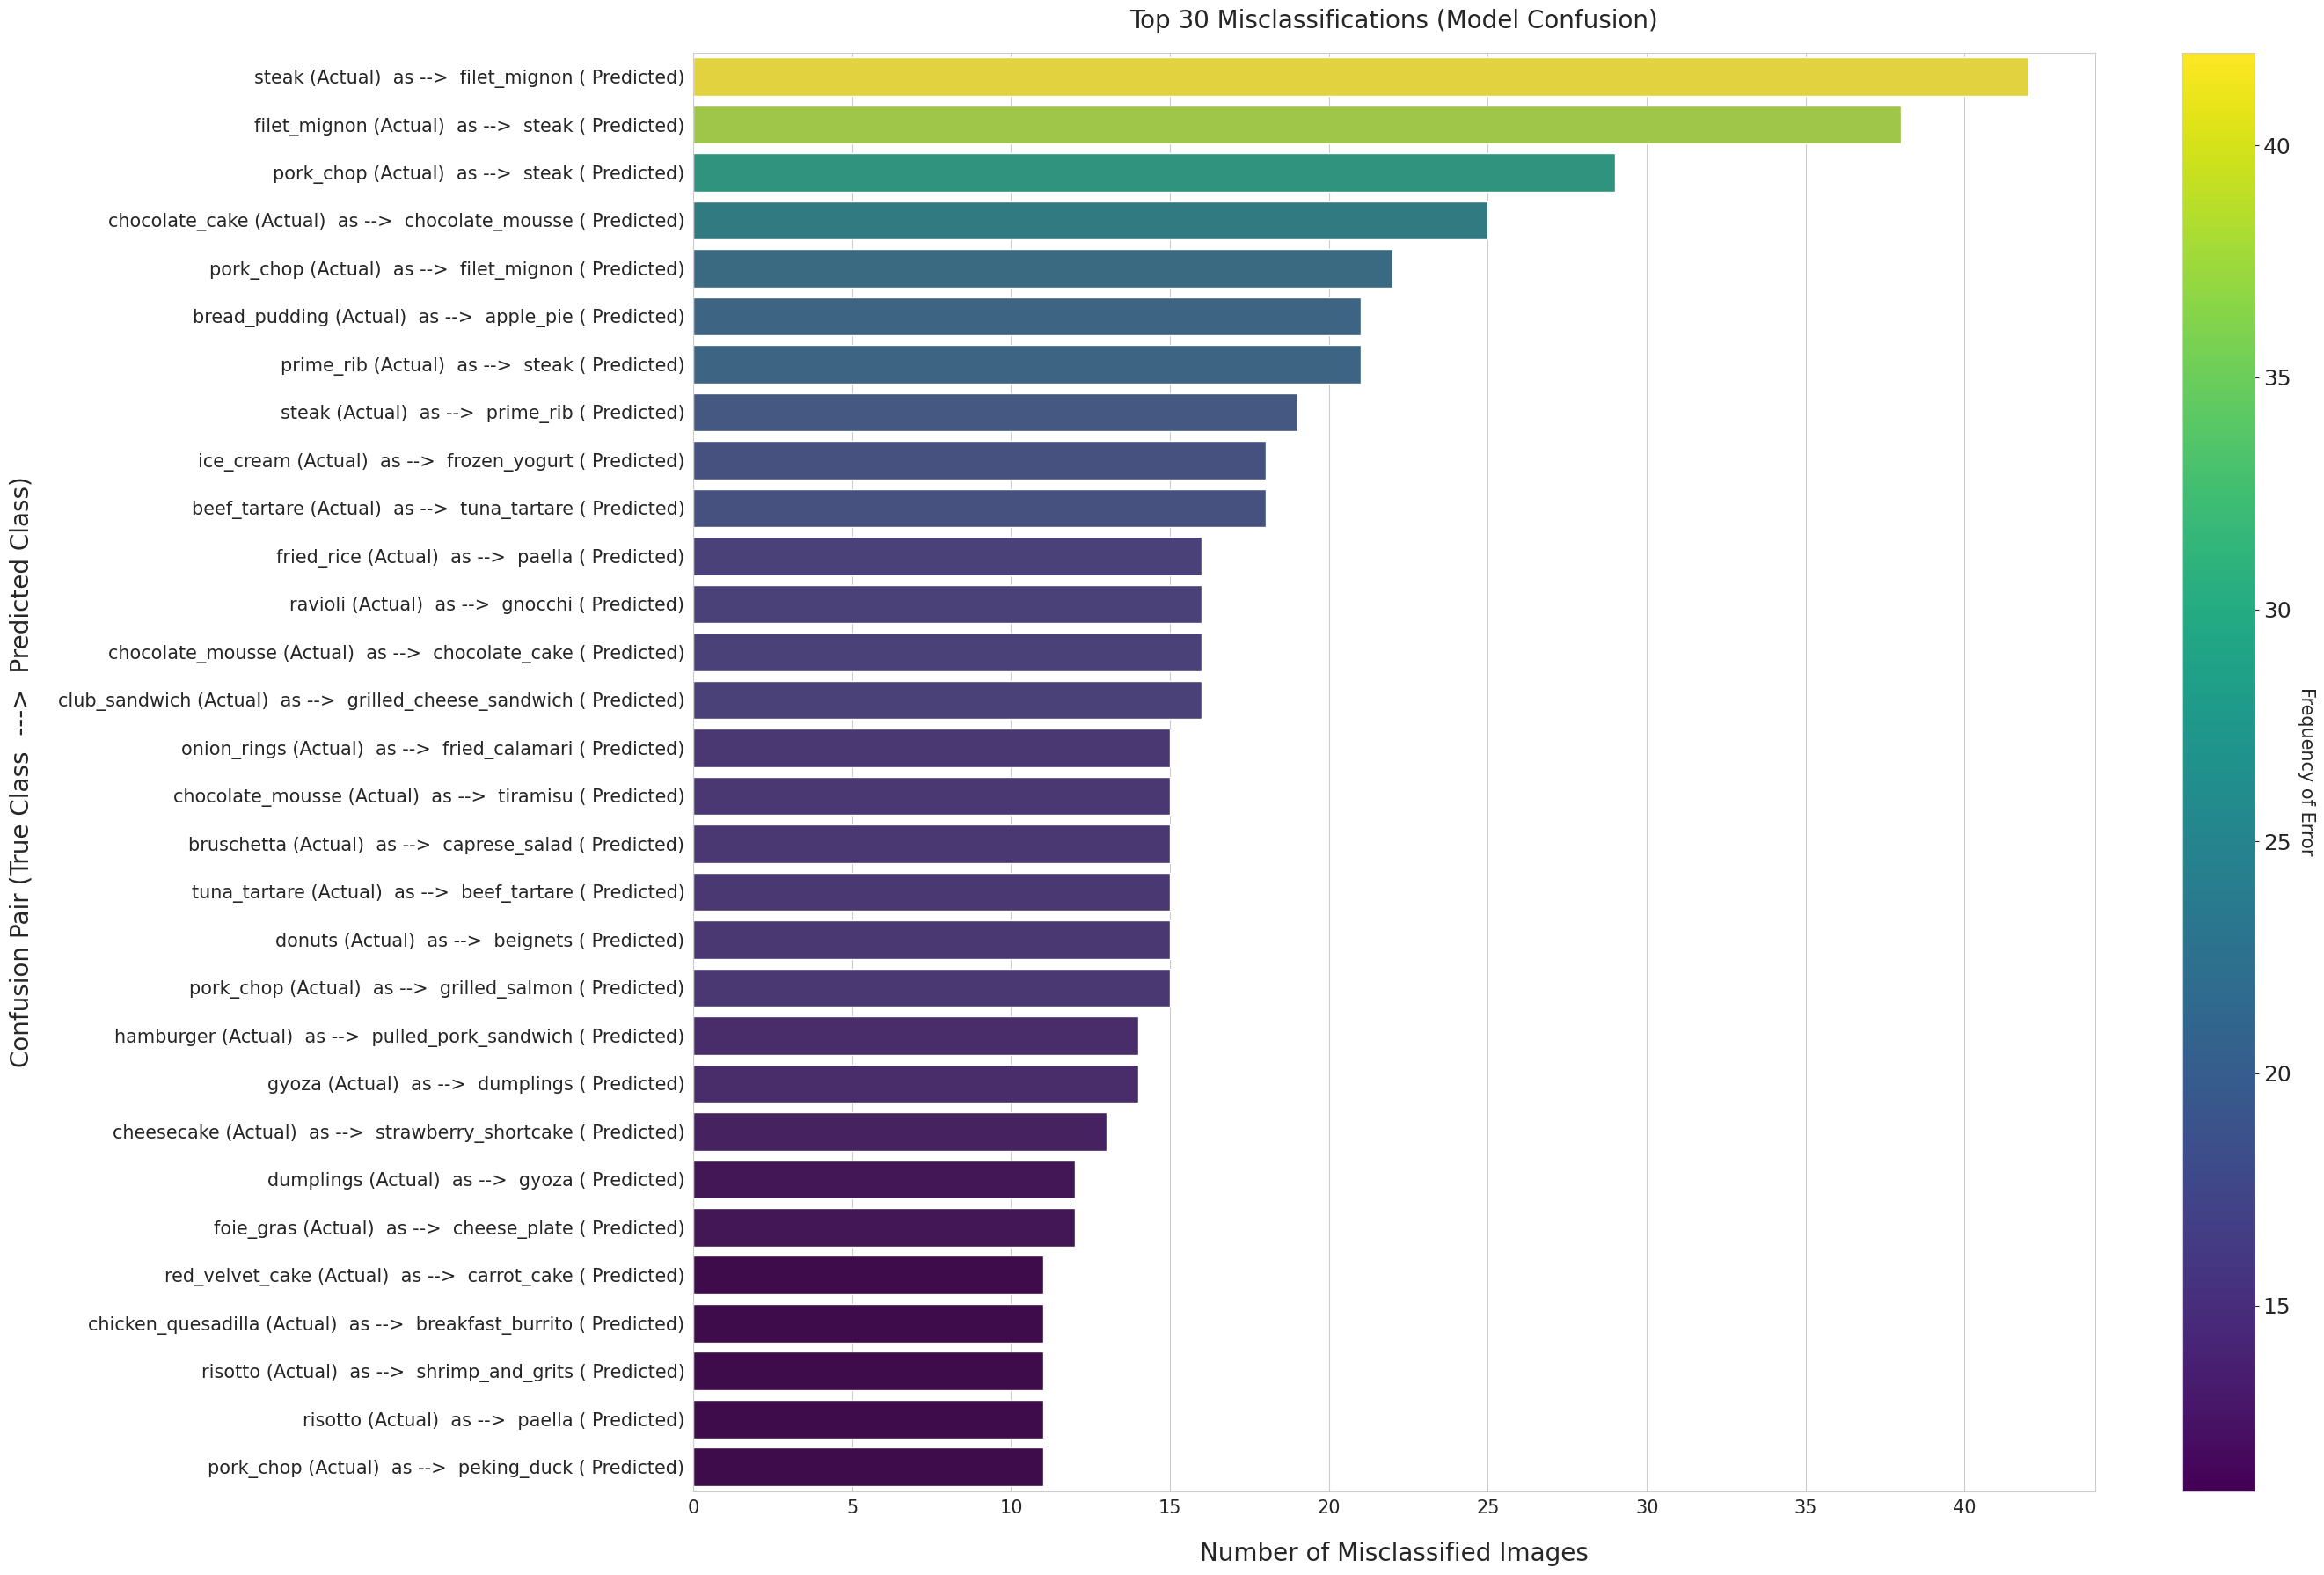

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

def plot_top_confusions(csv_path, top_k=30):
    """
    Loads a large confusion matrix CSV and plots the top k misclassification pairs
    """
    # 1. Load the Confusion Matrix
    try:
        cm_df = pd.read_csv(csv_path, index_col=0)
    except FileNotFoundError:
        print(f" Error: File '{csv_path}' not found.")
        return

    # 2. Extract Misclassifications
    confusions = []
    for true_label in cm_df.index:
        for pred_label in cm_df.columns:
            if true_label != pred_label: 
                count = cm_df.loc[true_label, pred_label]
                if count > 0:
                    confusions.append({
                        "True Class": true_label,
                        "Predicted Class": pred_label,
                        "Count": count
                    })
    
    # 3. Create DataFrame
    errors_df = pd.DataFrame(confusions)
    if errors_df.empty:
        print("No misclassifications found.")
        return

    # 4. Sort and Take Top K
    top_errors = errors_df.sort_values(by="Count", ascending=False).head(top_k)
    top_errors["Error Pair"] = top_errors["True Class"] + " (Actual)" + "  as -->  " + top_errors["Predicted Class"] + " ( Predicted)"

    # --- PLOTTING ---
    plt.figure(figsize=(28, 18))
    sns.set_style("whitegrid")
    
    # Color Map Setup
    norm = plt.Normalize(top_errors["Count"].min(), top_errors["Count"].max())
    sm = cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])

    # Bar Plot
    ax = sns.barplot(
        data=top_errors,
        y="Error Pair",
        x="Count",
        palette=sm.to_rgba(top_errors["Count"]),
        hue="Error Pair",
        legend=False
    )

    plt.tick_params(axis='y', labelsize=15) 
    plt.tick_params(axis='x', labelsize=15)

    # Add Colorbar
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Frequency of Error', rotation=270, labelpad=20, fontsize=15)
    cbar.ax.tick_params(labelsize=18) # Increase colorbar numbers size
    
    # Labels
    plt.title(f"Top {top_k} Misclassifications (Model Confusion)", fontsize=20, pad=20)
    plt.xlabel("Number of Misclassified Images", fontsize=20, labelpad=20)
    plt.ylabel("Confusion Pair (True Class  --->  Predicted Class)", fontsize=20, labelpad=20)
    
    plt.tight_layout()
    
    filename = "AIFood_EffB3_top_confusions_plot.png"
    plt.savefig(filename, dpi=300)
    print(f" Saved large plot to '{filename}'")
    plt.show()

# --- Run ---
plot_top_confusions("EffB3_confusion_matrix.csv", top_k=30)


--- Generating Visual Confusion Matrix (Heatmap) ---
Confusion matrix saved as 'AIFood_confusion_matrix_heatmap.png'. Open this file externally to zoom in.


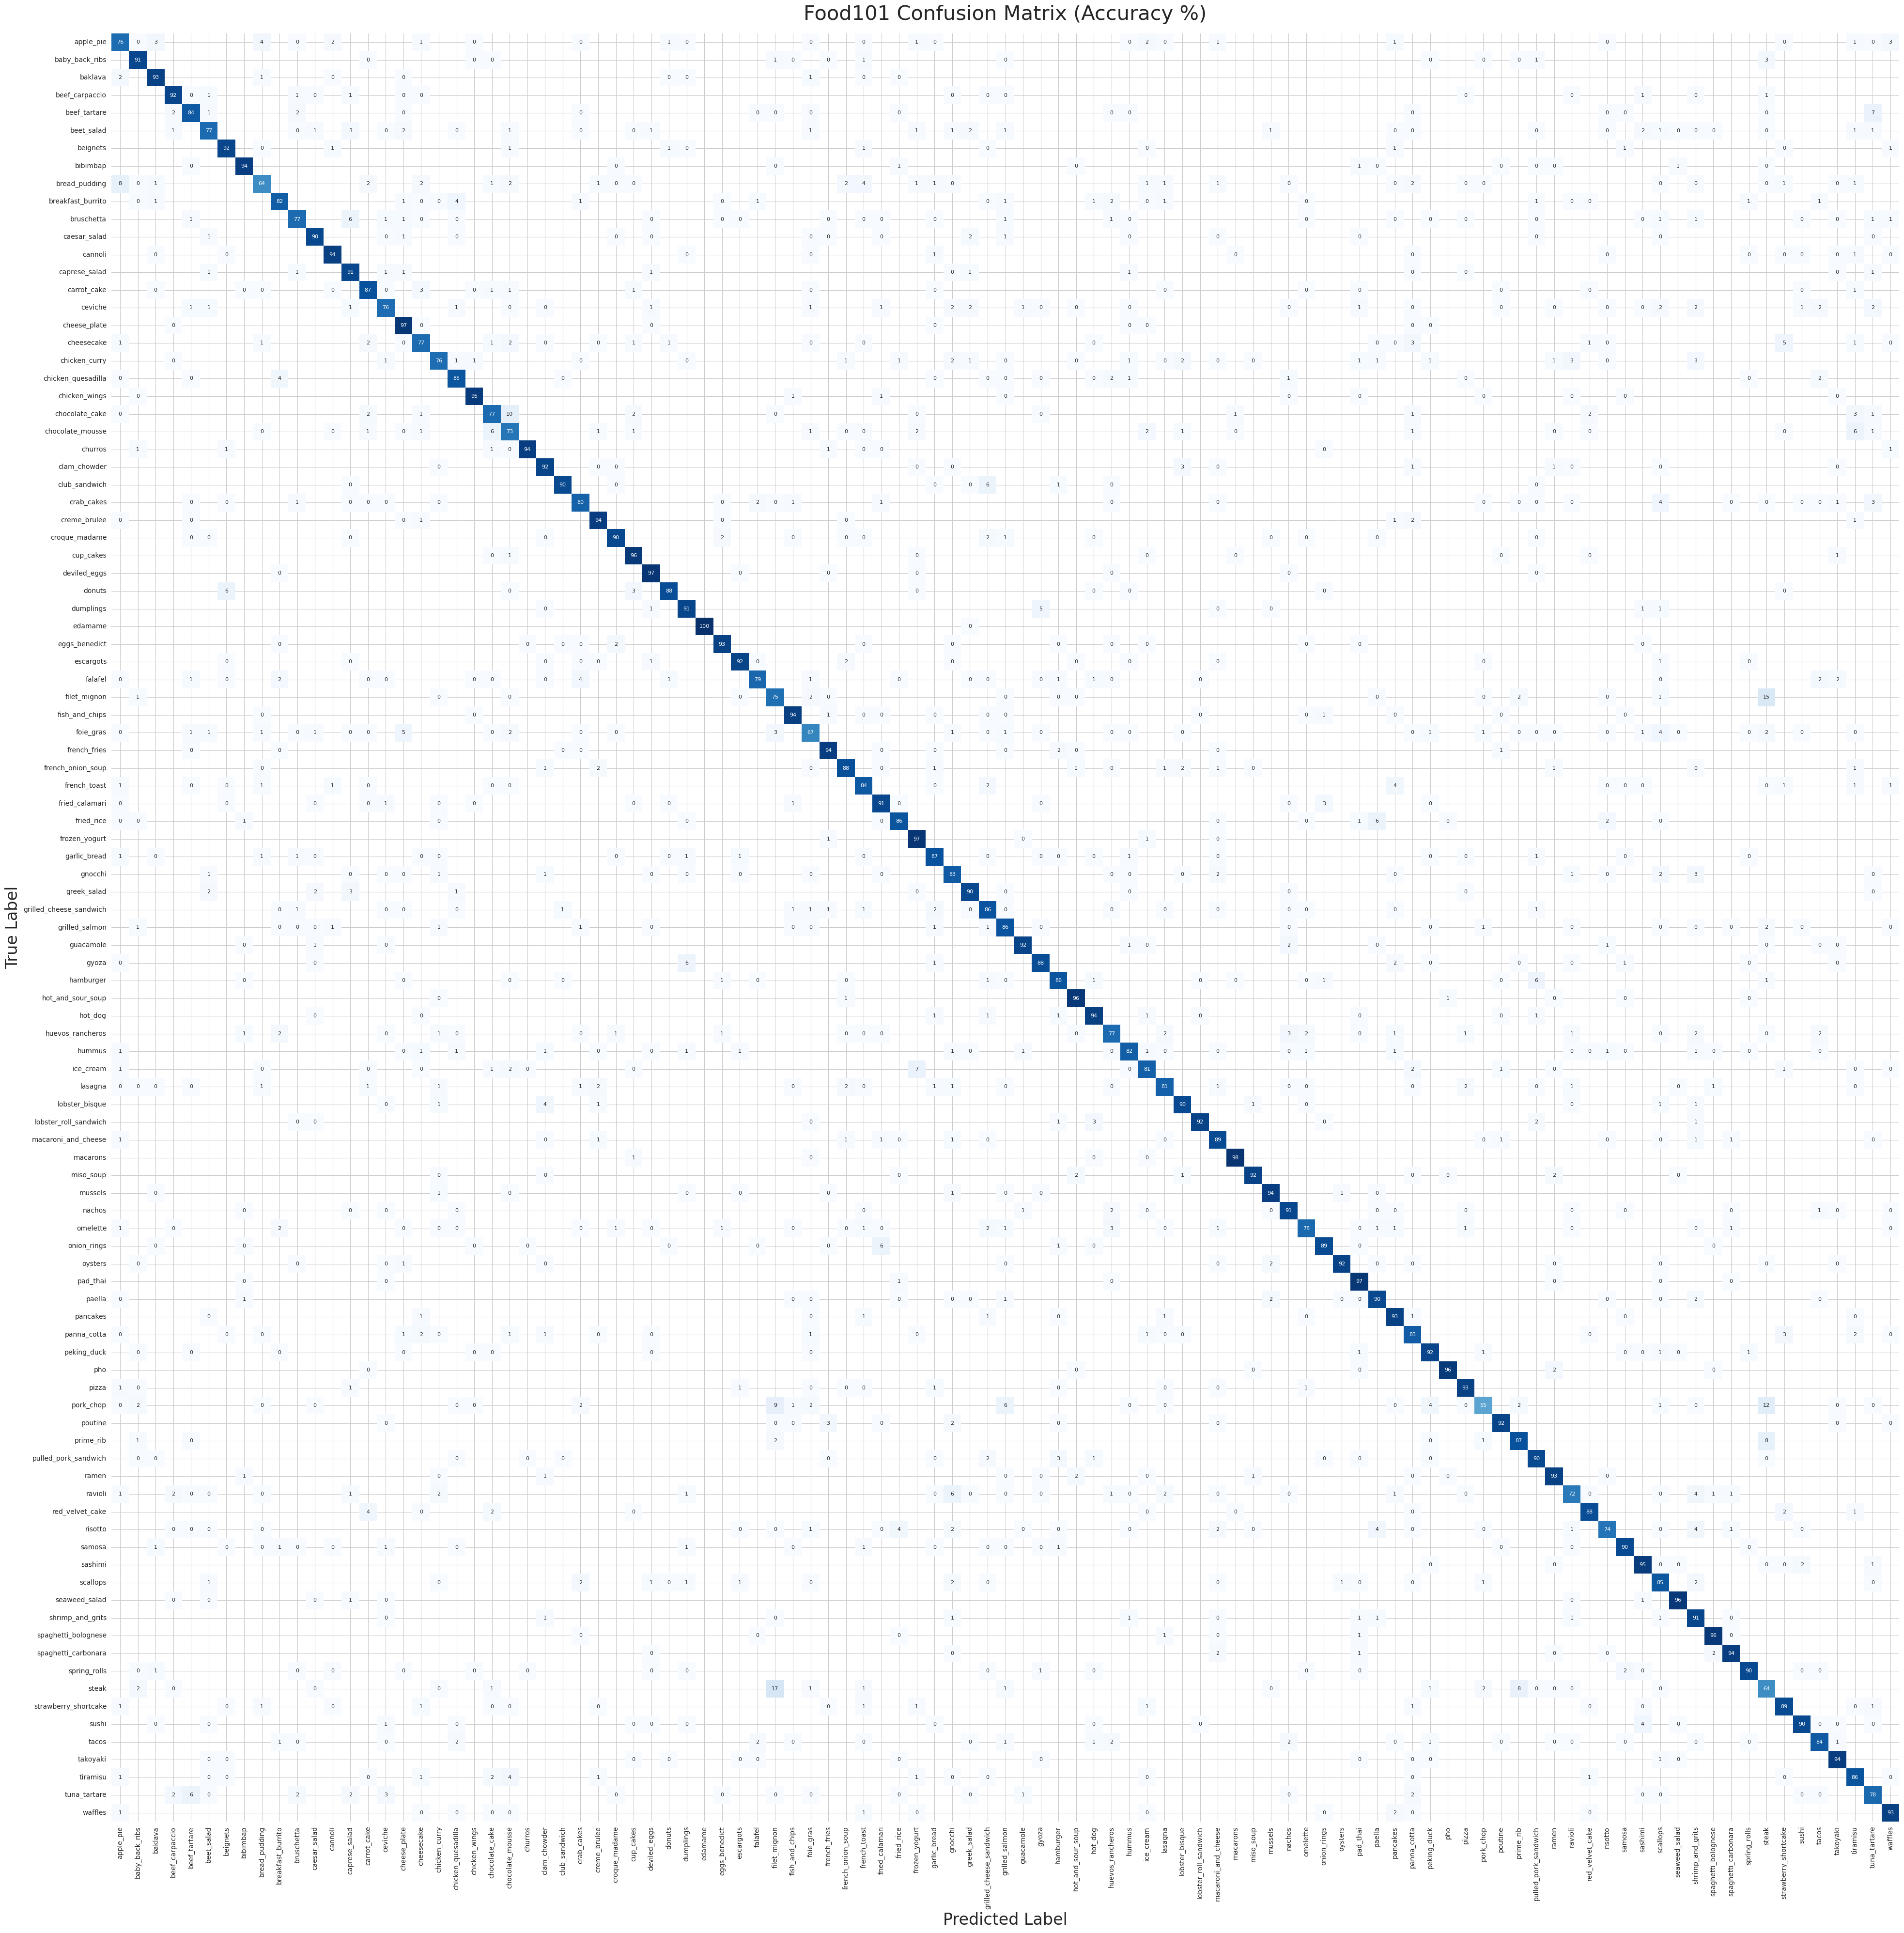

In [18]:
# =================  VISUALIZE CONFUSION MATRIX (Food101) =================
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

print("\n--- Generating Visual Confusion Matrix (Heatmap) ---")

# --- 1. Preparation ---
# Validate that variables from the previous loop exist
if 'y_true' not in globals() or 'y_preds' not in globals():
    raise NameError("Error: y_true and y_preds not found. Please run the Evaluation Loop first.")

# Use the target_names we defined in the previous step (or fallback)
if 'target_names' not in globals():
    target_names = [str(i) for i in range(101)]

# --- 2. Calculate Matrix ---
cm = confusion_matrix(y_true, y_preds)

# Calculate Normalized Matrix (Percentages)
# Add epsilon to sum to avoid division by zero if a class has 0 samples
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)
cm_pct = cm_norm * 100 

# --- 3. Plotting Setup ---
# A 101x101 matrix requires a massive canvas
plt.figure(figsize=(40, 40)) 

# Create a mask to hide perfectly predicted zeroes (reduces visual clutter)
mask = (cm_pct == 0)

# --- 4. Draw Heatmap ---
sns.heatmap(
    cm_pct, 
    annot=True,             # Show the numbers inside cells
    fmt='.0f',              # Format as integer (e.g., "85" instead of "85.432")
    mask=mask,              # Hide zero values for clarity
    cmap="Blues",           # Blue color scheme
    xticklabels=target_names, 
    yticklabels=target_names,
    cbar=False,             # Remove color bar to maximize plot area
    square=True,            # Force cells to be square
    annot_kws={"size": 8}   # Font size for the numbers
)

plt.title("Food101 Confusion Matrix (Accuracy %)", fontsize=30, pad=20)
plt.xlabel("Predicted Label", fontsize=24)
plt.ylabel("True Label", fontsize=24)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

# --- 5. Save and Show ---
filename = "AIFood_confusion_matrix_heatmap.png"
plt.savefig(filename, dpi=300) # High DPI for zooming capability
print(f"Confusion matrix saved as '{filename}'. Open this file externally to zoom in.")
plt.show()

In [9]:
import torch
from torchvision import models

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Multi-GPU ---
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)


model = models.efficientnet_b3(weights=None)

# Must match training structure
in_features = model.classifier[1].in_features
model.classifier[1] = torch.nn.Sequential(
    torch.nn.Dropout(0.4),
    torch.nn.Linear(in_features, 101)
)

# Load checkpoint
state_dict = torch.load("AI_food_best_model.pth", map_location=DEVICE)
if any(k.startswith("module.") for k in state_dict.keys()):
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_state_dict[k.replace("module.", "")] = v
    state_dict = new_state_dict

model.load_state_dict(state_dict)
model = model.to(DEVICE)
model.eval()

print("Model loaded successfully.")


Using 2 GPUs


/tmp/ipykernel_30813/4277774969.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("AI_food_best_model.pth", map_location=DEVICE)


Model loaded successfully.


In [10]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
from PIL import Image
from torchvision import models, transforms, datasets
from collections import OrderedDict
import matplotlib.pyplot as plt


# -------------------- TEST DATA --------------------
DATA_ROOT = "./data"
test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=num_cpu, pin_memory=True, prefetch_factor=2)

# -------------------- GRADCAM CLASS --------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        # Only forward + full backward hook to avoid conflict
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot)
        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = F.relu((weights * self.activations).sum(1, keepdim=True))
        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (224,224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam, class_idx

# -------------------- SELECT TARGET LAYER --------------------
model_to_use = model.module if hasattr(model, "module") else model

# Select the last conv layer with spatial dimensions >1
for name, module in reversed(list(model_to_use.named_modules())):
    if isinstance(module, torch.nn.Conv2d):
        if module.kernel_size != (1,1):  # skip 1x1 convs
            target_layer = module
            break
print(f"Selected target layer for Grad-CAM: {target_layer}")


# -------------------- INIT GRADCAM --------------------
gradcam = GradCAM(model_to_use, target_layer)





Selected target layer for Grad-CAM: Conv2d(2304, 2304, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2304, bias=False)


/home/haroonwaheed_19/miniconda3/envs/fyp/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Predicted class: carrot_cake
Actual class: carrot_cake


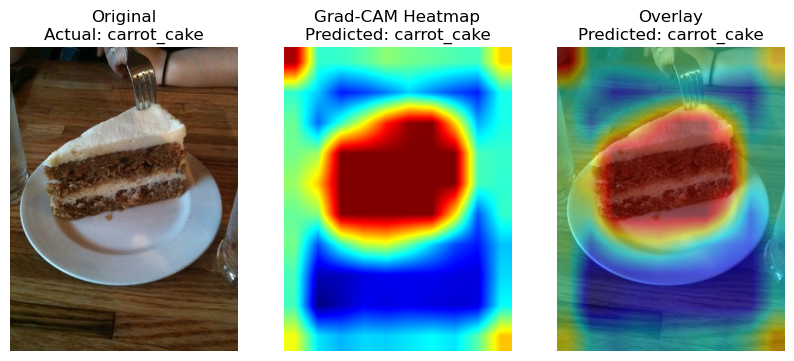

In [ ]:
# Load classes
with open("./data/food-101/meta/classes.txt", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

def load_image(path, device=DEVICE):
    img = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0).to(device), img

def extract_true_label(path):
    return path.split("/")[-2]  # folder name is class

def show_gradcam(img_pil, cam, pred_class=None, true_label=None):
    img_np = np.array(img_pil).astype(np.float32)/255
    heatmap = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap)/255
    overlay = 0.5*heatmap + 0.5*img_np
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow(img_np); plt.axis("off"); plt.title(f"Original\nActual: {true_label}")
    plt.subplot(1,3,2); plt.imshow(heatmap); plt.axis("off"); plt.title(f"Grad-CAM Heatmap\nPredicted: {pred_class}")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.axis("off"); plt.title(f"Overlay\nPredicted: {pred_class}")
    plt.show()

# Example usage
image_path = "./data/food-101/images/carrot_cake/35062.jpg"
true_label = extract_true_label(image_path)
input_tensor, orig_img = load_image(image_path)
cam, pred_idx = gradcam.generate(input_tensor)
pred_class_name = class_names[pred_idx]

print(f"Predicted class: {pred_class_name}")
print(f"Actual class: {true_label}")
show_gradcam(orig_img, cam, pred_class=pred_class_name, true_label=true_label)
